# Feature Selection 特征选择

数据预处理后，我们生成了大量的新变量（比如独热编码生成了大量仅包含0或1的变量）。但实际上，部分新生成的变量可能是多余：一方面它们本身不一定包含有用的信息，故无法提高模型性能；另一方面过这些多余变量在构建模型时会消耗大量内存和计算能力。因此，我们应该进行特征选择并选择特征子集进行建模。

## Filter Methods 过滤法

过滤法通过使用一些统计量或假设检验结果为每个变量打分。得分较高的功能往往更加重要，因此应被包含在子集中。以下为一个简单的基于过滤法的机器学习工作流（以最简单的训练-验证-测试这种数据集划分方法为例）。

### Univariate Filter Methods 单变量特征过滤

单变量过滤方法依据单变量统计量或统计检验选择最佳特征。其仅仅考虑单个变量与目标变量的关系（方差选择法仅基于单个变量）。

#### Variance Threshold 方差选择法

方差选择法删除变量方差低于某个阈值的所有特征。例如，我们应删除方差为零的特征（所有观测点中具有相同值的特征），因为该特征无法解释目标变量的任何变化。

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# 合成一些数据集用于演示
train_set = np.array([[1,2,3],[1,4,7],[1,4,9]]) # 可见第一个变量方差为0
# array([[1, 2, 3],
#        [1, 4, 7],
#        [1, 4, 9]])

test_set = np.array([[3,2,3],[1,2,7]]) # 故意将第二个变量方差设为0
# array([[3, 2, 3],
#        [1, 2, 7]])

selector = VarianceThreshold()
selector.fit(train_set) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
# 下面为返回结果，可见第一个变量已被删除
# array([[2, 3],
#        [4, 7],
#        [4, 9]])

transformed_test = selector.transform(test_set) # 转换测试集
# 下面为返回结果，可见第一个变量已被删除
# array([[2, 3],
#        [2, 7]])
# 虽然测试集中第二个变量的方差也为0
# 但是我们的选择是基于训练集，所以我们依然删除第一个变量

#### Pearson Correlation (regression problem)  皮尔森相关系数 (回归问题)

皮尔森相关系数一般用于衡量两个**连续**变量之间的线性相关性，也可以用于衡量二元变量与目标变量的相关性。故可以将类别变量利用独热编码转换为多个二元变量之后利用皮尔森相关系数进行筛选。

公式：
$r = \frac{\sum_{i=1}^{n}(X_i-\bar{X})(Y_i-\bar{Y})}{\sqrt{(X_i-\bar{X})^2}\sqrt{(Y_i-\bar{Y})^2}}$

In [2]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示
# 此数据集中，X，y均为连续变量，故此满足使用皮尔森相关系数的条件

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# sklearn 中没有直接的函数可以使用
# 此处将用 scipy.stats.pearsonr函数来实现基于皮尔森相关系数的特征过滤
# 注意 scipy.stats.pearsonr 计算的是两个变量之间的相关系数
# 因sklearn SelectKBest需要，我们将基于scipy.stats.pearsonr 重写允许多特征同时输入的函数 udf_pearsonr

def udf_pearsonr(X, y):
    # 将会分别计算每一个变量与目标变量的关系
    result = np.array([pearsonr(x, y) for x in X.T]) # 包含(皮尔森相关系数, p值) 的列表
    return np.absolute(result[:,0]), result[:,1] 

# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为皮尔森相关系数
selector = SelectKBest(udf_pearsonr, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(15000, 2), 其选择了第一个及第七个变量 
assert np.array_equal(transformed_train, train_set[:,[0,6]]) 

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[0,6]]);
# 可见对于测试集，其依然选择了第一个及第七个变量 

In [3]:
# 验算一下我们的结果
for idx in range(train_set.shape[1]):
    pea_score, p_value = pearsonr(train_set[:,idx], train_y)
    print(f"第{idx + 1}个变量和目标的皮尔森相关系数的绝对值为{round(np.abs(pea_score),2)}, p-值为{round(p_value,3)}")
# 应选择第一个及第七个变量 

第1个变量和目标的皮尔森相关系数的绝对值为0.7, p-值为0.0
第2个变量和目标的皮尔森相关系数的绝对值为0.07, p-值为0.0
第3个变量和目标的皮尔森相关系数的绝对值为0.14, p-值为0.0
第4个变量和目标的皮尔森相关系数的绝对值为0.04, p-值为0.0
第5个变量和目标的皮尔森相关系数的绝对值为0.02, p-值为0.011
第6个变量和目标的皮尔森相关系数的绝对值为0.05, p-值为0.0
第7个变量和目标的皮尔森相关系数的绝对值为0.23, p-值为0.0
第8个变量和目标的皮尔森相关系数的绝对值为0.08, p-值为0.0


#### Distance Correlation (regression problem) 距离相关系数 (回归问题)

与皮尔森相关系数类似，距离相关系数也一般被用于衡量两个连续变量之间的相关性。但与皮尔森相关系数不同的是，距离相关系数还衡量了两个变量之间的非线性关联。

公式:  
  
首先，计算(n x n)距离矩阵dX。dX中的每一个元素为$dX_{ij}$ 。类似的，我们也可以计算距离矩阵dY，其中dY中的每个元素为$dY_{ij}$。$dX_{ij}$是为观测点i与观测点j之间的距离:     
  
$dX_{ij} = \left \| X_i - X_j \right \|$  
$dY_{ij} = \left \| Y_i - Y_j \right \|$
   
其次，我们计算如下双中心距离并更新距离矩阵。其中，$\bar{X_i}$为距离矩阵dX的第i行平均值，$\bar{X_j}$为距离矩阵dX的第j列的平均值， $\sum_i^N \sum_j^N dX_{ij}$ 为全局平均值： 
  
$dX_{ij} = dX_{ij} - \bar{X_i} - \bar{X_j} + \frac{1}{N^2} \sum_i^N \sum_j^N dX_{ij}$  
$dY_{ij} = dY_{ij} - \bar{Y_i} - \bar{Y_j} + \frac{1}{N^2} \sum_i^N \sum_j^N dY_{ij}$   
  
随后，我们便可以算出样本距离协方差及距离方差：  
  
$dCov^2 (X, Y) = \frac{1}{N^2} \sum_{i}^{N} \sum_{j}^{N} dX_{ij}dY_{ij}$  
$dVar^2(X) = Cov^2_D (X, X)$  
  
最后，距离相关系数$dCor(X,Y)$ 便为如下： 
  
$dCor(X,Y) = \frac{dCov_D(X, Y)}{\sqrt{dVar^2(X)}\sqrt{dVar^2(Y)} }$

In [4]:
import numpy as np
from dcor import distance_correlation
from dcor.independence import distance_covariance_test
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示
# 此数据集中，X，y均为连续变量，故此满足使用距离相关系数的条件

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# sklearn 中没有直接的函数可以使用
# 此处将用 dcor.distance_correlation函数来实现基于距离相关系数的特征过滤
# 注意 dcor.distance_correlation 计算的是两个变量之间的相关系数
# 因sklearn SelectKBest需要，我们将基于dcor.distance_correlation 重写允许多特征同时输入的函数 udf_dcorr

def udf_dcorr(X, y):
    # 将会分别计算每一个变量与目标变量的关系
    result = np.array([[distance_correlation(x, y), 
                        distance_covariance_test(x,y)[0]]for x in X.T]) # 包含(距离相关系数, p值) 的列表
    return result[:,0], result[:,1]

# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为距离相关系数
selector = SelectKBest(udf_dcorr, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(15000, 2), 其选择了第一个及第三个变量 
assert np.array_equal(transformed_train, train_set[:,[0,2]])

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[0,2]]);
# 可见对于测试集，其依然选择了第一个及第三个变量 

In [5]:
# 验算一下我们的结果
for idx in range(train_set.shape[1]):
    d_score = distance_correlation(train_set[:,idx], train_y)
    p_value = distance_covariance_test(train_set[:,idx], train_y)[0]
    print(f"第{idx + 1}个变量和目标的距离相关系数为{round(d_score,2)}, p-值为{round(p_value,3)}")
# 应选择第一个及第三个变量 

第1个变量和目标的距离相关系数为0.66, p-值为1.0
第2个变量和目标的距离相关系数为0.07, p-值为1.0
第3个变量和目标的距离相关系数为0.31, p-值为1.0
第4个变量和目标的距离相关系数为0.12, p-值为1.0
第5个变量和目标的距离相关系数为0.08, p-值为1.0
第6个变量和目标的距离相关系数为0.29, p-值为1.0
第7个变量和目标的距离相关系数为0.25, p-值为1.0
第8个变量和目标的距离相关系数为0.19, p-值为1.0


#### F-Score (regression problem) F-统计量 (回归问题)

F统计量（F-Score）用于检验线性回归模型的整体显著性。在sklearn中，其将对每一个变量分别建立一个一元的线性回归模型，然后分别报告每一个对应模型的F统计量。F-统计量的零假设是该线性模型系数不显著，在一元模型中，该统计量能够反映各变量与目标变量之间的线性关系。因此，我们应该选择具有较高F统计量的特征（更有可能拒绝原假设）。

公式：  
  
$F = \frac{(SST - SSR)/(p - 1)}{SSR/(n - p)} =  \frac{SST - SSR}{SSR/(n - 2)} =  \frac{R^2}{(1 - R^2)(n - 2)} = \frac{\rho ^2}{(1 - \rho ^2)(n - 2)}$  
 
其中:  

$SST = \sum_{i=1}^{n}(y_i - \overline{y}) ^2$  
  
$\overline{y} = \frac{1}{n} \sum_{i=1}^{n}y_i$  
  
$SSR = \sum_{i=1}^{n}(\widehat{y}_i - \overline{y})^2$  
  
$\widehat{y}_i$ 为模型预测值
  
  
SST为总平方和，SSR为回归平方和，p为线性回归自变量数（包括常数项，故在上述的一元线性模型中，p=2），$\rho$为自变量与因变量的线性相关系数，n为总观测数。因上述线性模型为一元线性模型，故可证$\rho^2 = R^2$。 

In [6]:
import numpy as np
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示
# 此数据集中，X，y均为连续变量，故此满足使用F统计量的条件

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# sklearn 中直接提供了函数用于计算F统计量
# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为F统计量
selector = SelectKBest(f_regression, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(15000, 2), 其选择了第一个及第七个变量 
assert np.array_equal(transformed_train, train_set[:,[0,6]]) 

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[0,6]]);
# 可见对于测试集，其依然选择了第一个及第七个变量 

In [7]:
# 验算一下我们的结果
for idx in range(train_set.shape[1]):
    score, p_value = f_regression(train_set[:,idx].reshape(-1,1), train_y)
    print(f"第{idx + 1}个变量的F统计量为{round(score[0],2)}, p-值为{round(p_value[0],3)}")
# 故应选择第一个及第七个变量 

第1个变量的F统计量为14111.79, p-值为0.0
第2个变量的F统计量为71.99, p-值为0.0
第3个变量的F统计量为317.04, p-值为0.0
第4个变量的F统计量为23.93, p-值为0.0
第5个变量的F统计量为6.54, p-值为0.011
第6个变量的F统计量为35.93, p-值为0.0
第7个变量的F统计量为846.61, p-值为0.0
第8个变量的F统计量为98.06, p-值为0.0


#### Mutual Information (regression problem) 互信息 (回归问题)

互信息（Mutual Information）衡量变量间的相互依赖性。其本质为熵差，即$H(X) - H(X|Y)，即知道另一个变量信息后混乱的降低程度$。当且仅当两个随机变量独立时MI等于零。MI值越高，两变量之间的相关性则越强。与Pearson相关和F统计量相比，它还捕获了非线性关系。

公式:  
  
- 若两个变量均为离散变量:  
  
    $I(x, y) = H(Y) - H(Y|X) = \sum_{x\in \mathit{X}}  \sum_{x\in \mathit{Y}} \textit{p}_{(X,Y)}(x,y) \textrm{log}(\frac{\textit{p}_{(X,Y)}(x,y)}{\textit{p}_{X}(x)\textit{p}_{Y}(y)})$  

    $\textit{p}_{(X,Y)}(x,y)$ 为x和y的联合概率质量函数 (PMF)， $\textit{p}_{X}(x)$则为x的联合概率质量函数 (PMF)。  
  
- 若两个变量均为连续变量:  

    $I(X, Y) = H(Y) - H(Y|X) = \int_X \int_Y  \textit{p}_{(X,Y)}(x,y) \textrm{log}(\frac{\textit{p}_{(X,Y)}(x,y)}{\textit{p}_{X}(x)\textit{p}_{Y}(y)}) \, \, dx dy$  
    
    $\textit{p}_{(X,Y)}(x,y)$ 为x和y的联合概率密度函数 (PDF)，$\textit{p}_{X}(x)$则为x的概率密度函数 (PDF)。连续变量情形下，在实际操作中，往往先对数据离散化分桶，然后逐个桶进行计算。
  

但是实际上，一种极有可能的情况是，x和y中的一个可能是离散变量，而另一个是连续变量。因此在sklearn中，它基于[1]和[2]中提出的基于k最临近算法的熵估计非参数方法。   
   
[1] A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.  
[2] B. C. Ross “Mutual Information between Discrete and Continuous Data Sets”. PLoS ONE 9(2), 2014. 

In [8]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示
# 此数据集中，X，y均为连续变量，故此满足使用MI的条件

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:].astype(float)
test_set = X[15000:,].astype(float)
train_y = y[0:15000].astype(float)

# KNN中的临近数是一个非常重要的参数
# 故我们重写了一个新的MI计算函数更好的来控制这一参数
def udf_MI(X, y):
    result = mutual_info_regression(X, y, n_neighbors = 5) # 用户可以输入想要的临近数
    return result

# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为F统计量
selector = SelectKBest(udf_MI, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(15000, 2), 其选择了第一个及第八个变量
assert np.array_equal(transformed_train, train_set[:,[0,7]])

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[0,7]]);
# 可见对于测试集，其依然选择了第一个及第八个变量

In [9]:
# 验算上述结果
for idx in range(train_set.shape[1]):
    score = mutual_info_regression(train_set[:,idx].reshape(-1,1), train_y, n_neighbors = 5)
    print(f"第{idx + 1}个变量与因变量的互信息为{round(score[0],2)}")
# 故应选择第一个及第八个变量

第1个变量与因变量的互信息为0.38
第2个变量与因变量的互信息为0.03
第3个变量与因变量的互信息为0.1
第4个变量与因变量的互信息为0.03
第5个变量与因变量的互信息为0.02
第6个变量与因变量的互信息为0.09
第7个变量与因变量的互信息为0.37
第8个变量与因变量的互信息为0.46


#### Chi-squared Statistics (classification problem) 卡方统计量 (分类问题)

卡方统计量主要用于衡量两个类别特征之间的相关性。sklearn提供了chi2函数用于计算卡方统计量。其输入的特征变量必须为布尔值或频率（故对于类别变量应考虑独热编码）。卡方统计量的零假设为两个变量是独立的，因为卡方统计量值越高，则两个类别变量的相关性越强。因此，我们应该选择具有较高卡方统计量的特征。

公式:  
  
$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{i,j} - E_{i,j})^2}{E_{i,j}} = n \sum_{i,j} p_ip_j(\frac{\frac{O_{i,j}}{n} - p_i p_j}{p_i p_j})^2$  
  
其中，$O_{i,j}$为在变量X上具有i-th类别值且在变量Y上具有j-th类别值的实际观测点计数。$E_{i,j}$ 为利用概率估计的应在在变量X上具有i-th类别值且在变量Y上具有j-th类别值的观测点数量。n为总观测数，$p_i$为在变量X上具有i-th类别值的概率，$p_j$为在变量Y上具有j-th类别值的概率。  
  
**值得注意的是，通过解析源代码，我们发现在sklearn中利用chi2计算出来的卡方统计量并不是统计意义上的卡方统计量**。当输入变量为布尔变量时，chi2计算值为该布尔变量为True时候的卡方统计量（我们将会在下文举例说明）。这样的优势是，独热编码生成的所有布尔值变量的chi2值之和将等于原始变量统计意义上的卡方统计量。  
  
举个简单的例子，假设一个变量I有0，1，2两种可能的值，则独特编码后一共会产生3个新的布尔值变量。这三个布尔值变量的chi2计算出来的值之和，将等于变量I与因变量直接计算得出的统计意义上的卡方统计量。

##### 解析sklearn中chi2的计算

In [10]:
# 首先，随机生成一个数据集
import pandas as pd
sample_dict = {'Type': ['J','J','J',
                        'B','B','B',
                        'C','C','C','C','C'], 
               'Output': [0, 1, 0, 
                          2, 0, 1,  
                          0, 0, 1, 2, 2,]}
sample_raw = pd.DataFrame(sample_dict)
sample_raw #原始数据，Output是我们的目标变量，Type为类别变量

Type  Output
0     J       0
1     J       1
2     J       0
3     B       2
4     B       0
5     B       1
6     C       0
7     C       0
8     C       1
9     C       2
10    C       2

In [11]:
# 下面利用独热编码生成布尔变量，并利用sklearn计算每一个布尔变量的chi2值
sample = pd.get_dummies(sample_raw)
from sklearn.feature_selection import chi2
chi2(sample.values[:,[1,2,3]],sample.values[:,[0]])
# 第一行为每一个布尔变量的chi2值

(array([0.17777778, 0.42666667, 1.15555556]),
 array([0.91494723, 0.8078868 , 0.56114397]))

In [12]:
# 下面直接计算原始变量Type与output统计学意义上的卡方统计量
# 首先，先统计每一个类别下出现的观测数，用于创建列联表
obs_df = sample_raw.groupby(['Type','Output']).size().reset_index()
obs_df.columns = ['Type','Output','Count']
obs_df

Type  Output  Count
0    B       0      1
1    B       1      1
2    B       2      1
3    C       0      2
4    C       1      1
5    C       2      2
6    J       0      2
7    J       1      1

即列联表（contingency table）为：  

| Type/Output | 0 | 1 | 2 |
|------|------|------|------|
|  B  | 1 | 1 | 1 |
|  C  | 2 | 1 | 2 |
|  J  | 2 | 1 | 0 |

In [13]:
from scipy.stats import chi2_contingency
obs = np.array([[1, 1, 1], [2, 1, 2],[2, 1, 0]])
chi2_contingency(obs) # 第一个值即为变量Type与output统计学意义上的卡方统计量

(1.7600000000000002,
 0.779791873961373,
 4,
 array([[1.36363636, 0.81818182, 0.81818182],
        [2.27272727, 1.36363636, 1.36363636],
        [1.36363636, 0.81818182, 0.81818182]]))

In [14]:
# 而chi2函数算出来的布尔值之和为即为原始变量的统计意义上的卡方统计量
chi2(sample.values[:,[1,2,3]],sample.values[:,[0]])[0].sum() == chi2_contingency(obs)[0]

True

In [15]:
# 那么sklearn中的chi2是如何计算的呢？
# 不妨以第一个生成的布尔值为例，即Type为B
# chi2出来的值为0.17777778
# 而这与利用scipy以下代码计算出的计算一致
from scipy.stats import chisquare
f_exp = np.array([5/11, 3/11, 3/11]) * 3 # 预期频数为 output的先验概率 * Type为B 观测数
chisquare([1,1,1], f_exp=f_exp) # [1,1,1] 即Type为B 的观测实际频数
# 即sklearn 中的chi2 仅考虑了Type为B情形下的列连表

Power_divergenceResult(statistic=0.17777777777777778, pvalue=0.9149472287300311)

##### 如何利用sklearn 来进行特征选择

In [16]:
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import load_iris # 利用iris数据作为演示数据集
iris = load_iris()
X, y = iris.data, iris.target
# 此数据集中，X为连续变量，y为类别变量
# 不满足chi2的使用条件

# 将连续变量变为布尔值变量以满足chi2使用条件
# 不妨利用其是否大于均值来生成布尔值（仅作为演示用）
X = X > X.mean(0)

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]

# sklearn 中直接提供了函数用于计算卡方统计量
# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为F统计量
selector = SelectKBest(chi2, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(100, 2), 其选择了第三个及第四个变量 
assert np.array_equal(transformed_train, train_set[:,[2,3]]) 

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[2,3]]);
# 可见对于测试集，其依然选择了第三个及第四个变量 

In [17]:
# 验证上述结果
for idx in range(train_set.shape[1]):
    score, p_value = chi2(train_set[:,idx].reshape(-1,1), train_y)
    print(f"第{idx + 1}个变量与因变量的卡方统计量为{round(score[0],2)}，p值为{round(p_value[0],3)}")
# 故应选择第三个及第四个变量 

第1个变量与因变量的卡方统计量为29.69，p值为0.0
第2个变量与因变量的卡方统计量为19.42，p值为0.0
第3个变量与因变量的卡方统计量为31.97，p值为0.0
第4个变量与因变量的卡方统计量为31.71，p值为0.0


#### F-Score (classification problem) F-统计量 (分类问题)

在分类机器学习问题中，若变量特征为类别特征，则我们可以使用独热编码配合上述chi2方法选择最重要的特征。但若特征为连续变量，则我们可以使用ANOVA-F值。ANOVA F统计量的零假设是若按目标变量（类别）分组，则连续变量的总体均值是相同的。故我们应选择具有高ANOVA-F统计量的连续变量，因为这些连续变量与目标变量的关联性强。

公式：  
  
$F = \frac{MSB}{MSE} = \frac{ \frac{SS(between)}{m-1}}{ \frac{SS(error)}{n-m}}$   
  
其中，SS(between)为组间的平方和，即组均值和总体均值之间的平方和。 SS(error)是组内的平方和，即数据与组均值之间的平方和。 m是目标变量的总类别数，n是观测数。

In [18]:
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import load_iris # 利用iris数据作为演示数据集
iris = load_iris()
X, y = iris.data, iris.target
# 此数据集中，X为连续变量，y为类别变量
# 满足ANOVA-F的使用条件

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]

# sklearn 中直接提供了函数用于计算ANOVA-F
# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为F统计量
selector = SelectKBest(f_classif, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(100, 2), 其选择了第三个及第四个变量 
assert np.array_equal(transformed_train, train_set[:,[2,3]]) 

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[2,3]]);
# 可见对于测试集，其依然选择了第三个及第四个变量 

In [19]:
# 验证上述结果
for idx in range(train_set.shape[1]):
    score, p_value = f_classif(train_set[:,idx].reshape(-1,1), train_y)
    print(f"第{idx + 1}个变量与因变量的ANOVA-F统计量为{round(score[0],2)}，p值为{round(p_value[0],3)}")
# 故应选择第三个及第四个变量 

第1个变量与因变量的ANOVA-F统计量为91.39，p值为0.0
第2个变量与因变量的ANOVA-F统计量为33.18，p值为0.0
第3个变量与因变量的ANOVA-F统计量为733.94，p值为0.0
第4个变量与因变量的ANOVA-F统计量为608.95，p值为0.0


#### Mutual Information (classification problem) 互信息 (分类问题)

【与1.1.1.5一样】互信息（Mutual Information）衡量变量间的相互依赖性。其本质为熵差，即$H(X) - H(X|Y)，即知道另一个变量信息后混乱的降低程度$。当且仅当两个随机变量独立时MI等于零。MI值越高，两变量之间的相关性则越强。与Pearson相关和F统计量相比，它还捕获了非线性关系。

公式:  
  
- 若两个变量均为离散变量:  
  
    $I(x, y) = H(Y) - H(Y|X) = \sum_{x\in \mathit{X}}  \sum_{x\in \mathit{Y}} \textit{p}_{(X,Y)}(x,y) \textrm{log}(\frac{\textit{p}_{(X,Y)}(x,y)}{\textit{p}_{X}(x)\textit{p}_{Y}(y)})$  

    $\textit{p}_{(X,Y)}(x,y)$ 为x和y的联合概率质量函数 (PMF)， $\textit{p}_{X}(x)$则为x的的联合概率质量函数 (PMF)。  
  
- 若两个变量均为连续变量:  

    $I(X, Y) = H(Y) - H(Y|X) = \int_X \int_Y  \textit{p}_{(X,Y)}(x,y) \textrm{log}(\frac{\textit{p}_{(X,Y)}(x,y)}{\textit{p}_{X}(x)\textit{p}_{Y}(y)}) \, \, dx dy$  
    
    $\textit{p}_{(X,Y)}(x,y)$ 为x和y的联合概率密度函数 (PDF)，$\textit{p}_{X}(x)$则为x的的联合概率密度函数 (PDF)。连续变量情形下，在实际操作中，往往先对数据离散化分桶，然后逐个桶进行计算。
  

但是实际上，一种极有可能的情况是，x和y中的一个可能是离散变量，而另一个是连续变量。因此在sklearn中，它基于[1]和[2]中提出的基于k最临近算法的熵估计非参数方法。   
   
[1] A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.  
[2] B. C. Ross “Mutual Information between Discrete and Continuous Data Sets”. PLoS ONE 9(2), 2014. 

In [20]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# 直接载入数据集
from sklearn.datasets import load_iris # 利用iris数据作为演示数据集
iris = load_iris()
X, y = iris.data, iris.target
# 此数据集中，X为连续变量，y为类别变量
# 满足MI的使用条件

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]

# KNN中的临近数是一个非常重要的参数
# 故我们重写了一个新的MI计算函数更好的来控制这一参数
def udf_MI(X, y):
    result = mutual_info_classif(X, y, n_neighbors = 5) # 用户可以输入想要的临近数
    return result

# SelectKBest 将会基于一个判别函数自动选择得分高的变量
# 这里的判别函数为F统计量
selector = SelectKBest(udf_MI, k=2) # k => 我们想要选择的变量数
selector.fit(train_set, train_y) # 在训练集上训练
transformed_train = selector.transform(train_set) # 转换训练集
transformed_train.shape #(100, 2), 其选择了第三个及第四个变量 
assert np.array_equal(transformed_train, train_set[:,[2,3]]) 

transformed_test = selector.transform(test_set) # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[2,3]]);
# 可见对于测试集，其依然选择了第三个及第四个变量 

In [21]:
# 验算上述结果
for idx in range(train_set.shape[1]):
    score = mutual_info_classif(train_set[:,idx].reshape(-1,1), train_y, n_neighbors = 5)
    print(f"第{idx + 1}个变量与因变量的互信息为{round(score[0],2)}")
# 故应选择第三个及第四个变量

第1个变量与因变量的互信息为0.56
第2个变量与因变量的互信息为0.28
第3个变量与因变量的互信息为0.99
第4个变量与因变量的互信息为1.02


### Multivariate Filter Methods 多元特征过滤

单变量特征过滤仅考虑了每一变量与目标变量之间的关系，而忽视了变量间的相关性。多元变量过滤则解决了这一问题，其考虑了变量之间的相互关系，基于整个特征空间选择最佳特征。因此多元特征过滤在删除冗余变量方面表现更好。这里利用亚利桑那州立大学开发的[skfeature](https://github.com/jundongl/scikit-feature)模块来进行多元特征过滤。

#### Max-Relevance Min-Redundancy (mRMR) 最大相关最小冗余

最大相关最小冗余试图寻找一个与目标变量有较高相关性（例如：MI）的变量子集，同时这个子集中的变量还应具有较低的相互关联性。通过解析源代码，我们发现，skfeature中最大相关最小冗余方法仅适用于分类问题中的离散特征，因为它计算过程中使用的是计算离散情形下的互信息 (MI)的公式。

公式：  
假设数据集共包含m个特征，则基于mRMR公式，其中第n个特征的重要性可被表示为：

$f^{mRMR}(X_i) = I(Y, X_i) - \frac{1}{|S|}\sum_{X_s \in S} I(X_s, X_i)$  
  
$I(Y, X_i)$为变量$X_i$与目标变量Y的互信息。$\frac{1}{|S|}\sum_{X_s \in S} I(X_s, X_i)$为变量$X_i$与现有变量子集中所有变量的互信息的平均值。      
  
mRMR其实是一个逐步（step-wise）的方法，在mRMR特征选择过程的每一步中，具有最高特征重要性$f^{mRMR}(X_i)$的变量$X_i, (X_i \notin  S)$将会被加入子集中，直至子集中的变量数达到用户要求。

In [22]:
import numpy as np
from skfeature.function.information_theoretical_based import MRMR
from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点作为测试集
# 由于skfeature中的mRMR仅适用于离散变量
# 因此我们通过将float转换为int而把所有连续变量转换为离散变量
# 此转换仅用于演示目的

train_set = X[0:100,:].astype(int)
test_set = X[100:,].astype(int)
train_y = y[0:100].astype(int)

feature_index,_,_ = MRMR.mrmr(train_set, train_y, n_selected_features=2) # 在训练集上训练
transformed_train = train_set[:,feature_index] # 转换训练集
assert np.array_equal(transformed_train, train_set[:,[2,3]])  # 其选择了第三个及第四个变量 

transformed_test = test_set[:,feature_index] # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[2,3]]) # 其选择了第三个及第四个变量 

#### Correlation-based Feature Selection (CFS) 基于相关性的特征选择

与mRMR类似，基于相关性的特征选择（CFS）也基于一个类似的假设：一个好的特征子集应包含与目标高度相关且彼此不相关的特征。 通过解析源代码，我们发现，skfeature中CFS的实现也仅适用于分类问题中的离散特征。因为其使用的是离散情形下的对称不确定性（symmetrical uncertainty）作为变量间相关性的衡量标准。

公式：  
  
$Merit_S =\frac{ \sum_{i=1}^{k} SU(X_i, y)}{\sqrt{k + \sum_{i=1}^{k} \sum_{j=1}^{k} SU(X_i, X_j) }}, \, \, \, X_i \in S^*$  
  
$SU(X, Y) = 2 * \frac{H(X) + H(Y) - H(X|Y)}{H(X) + H(Y)}$  
  
$S$为特征子集. 我们需要寻找最大化$Merit_S$的最优子集$S^*$。  
$SU(X_i, y)$为离散变量$X_i$与目标变量$y$间的对称不确定性（SU）。     
$SU(X_i, X_j)$为离散变量$X_i$与离散变量$X_j$间的对称不确定性（SU）。  

In [23]:
import numpy as np
from skfeature.function.statistical_based import CFS
from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点作为测试集
# 由于skfeature中的CFS仅适用于离散变量
# 因此我们通过将float转换为int而把所有连续变量转换为离散变量
# 此转换仅用于演示目的

train_set = X[0:100,:].astype(int)
test_set = X[100:,].astype(int)
train_y = y[0:100].astype(int)

num_feature = 2 # 从原数据集中选择两个变量

feature_index = CFS.cfs(train_set, train_y) # 在训练集上训练
transformed_train = train_set[:,feature_index[0:num_feature]] # 转换训练集
assert np.array_equal(transformed_train, train_set[:,[3,2]])  # 其选择了第三个及第四个变量 

transformed_test = test_set[:,feature_index[0:num_feature]] # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[3,2]]) # 其选择了第三个及第四个变量 

#### Fast Correlation-based Filter (FCBF) 基于相关性的快速特征选择

相比于CFS，FCBS能够更加高效的筛选变量。其同样为逐步（step-wise）的方法，具体步骤与mRMR非常类似，但FCBS使用对称不确定性（SU）衡量变量间的关联性。FCBF首先剔除与目标变量具有较低SU值的变量，并对剩下的变量按与目标变量的SU值从最高到最低排序，然后逐一删除冗余特征。与mRMR，CFS相似，在skfeature中实现的FCBF仅适用于具有离散变量的分类问题。

公式：  
  
$SU(X, Y) = 2 * \frac{H(X) + H(Y) - H(X|Y)}{H(X) + H(Y)}$   
  
步骤：  
  
1)计算每个特征变量$X_i$与目标变量$y$之间的相关性$SU(X_i,y)$  
2)仅保留$SU(X_i,y)$大于一定阈值$\sigma$的特征变量，组成候选列表$S_{list}$  
3)按照$SU(X_i,y)$值的大小对$S_{list}$中的变量从大到小排序  
4)按顺序依次计算每一个特征$X_i$与候选列表$S_{list}$中顺序靠后的每一个特征$X_j$的相关SU值$SU(X_i,X_j)$  
5)若$SU(X_i,X_j)$大于$SU(X_j,y)$，则从候选列表$S_{list}$ 中删除$X_j$

In [24]:
import numpy as np
from skfeature.function.information_theoretical_based import FCBF
from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点作为测试集
# 由于skfeature中的FCFS仅适用于离散变量
# 因此我们通过将float转换为int而把所有连续变量转换为离散变量
# 此转换仅用于演示目的

train_set = X[0:100,:].astype(int)
test_set = X[100:,].astype(int)
train_y = y[0:100].astype(int)

num_feature = 2 # 从原数据集中选择两个变量

feature_index = FCBF.fcbf(train_set, train_y, n_selected_features = num_feature)[0] # 在训练集上训练
transformed_train = train_set[:,feature_index[0:num_feature]] # 转换训练集
assert np.array_equal(transformed_train, train_set[:,[3, 2]])  # 其选择了第三个及第四个变量 
# 这是由于其他变量目标变量𝑦之间的相关性过低造成的

transformed_test = test_set[:,feature_index[0:num_feature]] # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[3, 2]]) # # 其选择了第三个及第四个变量 

#### ReliefF

ReliefF方法是一种基于Relief方法的特征加权算法。在Relief方法中，其根据特征与目标变量的相关性强弱（二分类）给变量分配权重，并删除权重低于特定阈值的特征。其将相关性定义为变量区分邻近观测点的能力。

具体来说，在每一步中，Relief方法都会从训练集中随机选择一个观测点S，然后找到具有相同目标标签的S的最近邻观测点，称为NearHit。它还将找到具有不同目标标签的S的最近邻观测点，称为NearMiss。然后根据以下规则更新每个功能的权重：

1）若观测点S在某变量上与NearHit的距离大于与NearMiss的距离，则该变量的权重将增加，因为变量有助于区分最邻近情形下的目标标签。2）相反，若观测点S在某变量上与NearHit的距离小于与NearMiss的距离，则该变量的权重会降低。

将上述过程重复m次，最后我们会获得每个特征变量的平均权重。特征变量的权重越大，则特征的分类能力越强，越应该被留在最终的特征子集中。

在ReliefF中，其修改了权重更新的方式，因此ReliefF方法可以被应用于多类分类问题。另外，它随机采样K个最近的观测点而不是一个。

在skfeature中实现的ReliefF可用于分类问题中的连续特征或二元类别特征，因其使用的是L1范数来衡量差异。针对非二元特征，我们可以先将其独热编码，再使用ReliefF方法。

公式：  

Formula:  
  
$W(X_i) = W(X_i) - \frac{\sum_{i=1}^{k} diff(X_i, S, H_j) }{m*k} + \frac{\sum_{C\notin class(S)} [\frac{p(C)}{1-P(class(S))} \sum_{i=1}^{k} diff(X_i, S, M_j(C)) ]}{m*k}$  

$diff(X_i, R_1, R_2) = \left\{\begin{matrix}
\frac{|R_1(X_i) - R_2(X_i)|}{max(X_i)- min(X_i)} & 若X_i\ 为连续变量\\ 
 0 & 若X_i为类别变量且\ R_1(X_i) =R_2(X_i)\\ 
 1 & 若X_i为类别变量且 \ R_1(X_i) \neq R_2(X_i)
\end{matrix}\right.$ 
  
$R_1$ and $R_2$ 为任意两个观测点。$X_i$为某一特征变量. S为我们选择的观测点. $H_j$为第j个NearHit，$M_j$为第j个NearMiss. C为与我们所选的观测点不同的其他目标类别标签。

In [25]:
import numpy as np
from skfeature.function.similarity_based import reliefF
from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点作为测试集
# skfeature中的reliefF直接适用于连续变量

train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]

num_feature = 2 # 从原数据集中选择两个变量

score = reliefF.reliefF(train_set, train_y) # 计算每一个变量的权重
feature_index = reliefF.feature_ranking(score) # 依据权重选择变量
transformed_train = train_set[:,feature_index[0:num_feature]] # 转换训练集
assert np.array_equal(transformed_train, train_set[:,[2, 3]])  # 其选择了第三个及第四个变量 

transformed_test = test_set[:,feature_index[0:num_feature]] # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[2, 3]]) # 其选择了第三个及第四个变量 

#### Spectral Feature Selection (SPEC) 基于谱图的特征选择

基于谱图的特征选择(SPEC)方法是基于谱图理论的无监督方法。其首先建立变量相似度集合S，并建立其图表示。然后，其根据构造图的频谱评估特征。由于在skfeature中实现的SPEC方基于RBF（高斯）内核建立相似集，因此其可用于分类问题中的连续特征或二元类别特征。针对非二元特征，我们可以先将其独热编码，再使用ReliefF方法。

In [26]:
import numpy as np
from skfeature.function.similarity_based import SPEC
from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点作为测试集
# skfeature中的SEPC方法直接适用于连续变量

train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]

num_feature = 2 # 从原数据集中选择两个变量

score = SPEC.spec(train_set) # 计算每一个变量的得分
feature_index = SPEC.feature_ranking(score) #依据变量得分选择变量
transformed_train = train_set[:,feature_index[0:num_feature]] # 转换训练集
assert np.array_equal(transformed_train, train_set[:,[1, 0]])  # 其选择了第一个及第二个变量 

transformed_test = test_set[:,feature_index[0:num_feature]] # 转换测试集
assert np.array_equal(transformed_test, test_set[:,[1, 0]]) # 其选择了第一个及第二个变量 

## Wrapper Methods 封装方法

封装方法将特征选择问题视作搜索问题，即其目标为从特征子集集合中搜索出一个最佳的子集，而这一子集在模型中表现最佳。在每一步中，其在特征子集上训练模型，然后对其进行评估，并在下一步继续调整特征子集,重新训练评估，直到找到最佳子集或达到最大迭代次数为止。穷尽搜索在封装方法中为NP-Hard，故人们提出了一些方法来降低封装方法所需要的迭代次数，以便可以在有限的时间内达到一个较好的效果。

![image](../images/封装法工作流.png)

### Deterministic Algorithms 确定性算法

在不考虑模型随机性的情况下，给定相同的数据输入，确定性算法将始终输出相同的最优特征子集。顺序向前选择（SFS），顺序向后选择（SBS）均为确定性算法。

顺序向前选择（SFS）方法将从最优单变量模型开始，然后在迭代中，其会在上一步变量子集的基础上，以穷举的方法在现有变量子集中增加一个新变量，使得新增一个变量后的变量子集可以获得最大的模型表现提升。迭代将持续直到所选变量的数量满足要求为止。

顺序向后选择（SBS）则从适合一个包含所有变量的模型开始，然后在迭代中，其会在上一步变量子集的基础上，以穷举的方法在现有变量子集中删除一个对模型负影响最低的变量，直到所选特征的数量满足要求为止。

但是顺序向前选择（SFS）方法和顺序向后选择（SBS）均为逐步（step-wise）的方法，都可能会陷入局部最优状态。

#### Recursive Feature Elimination (SBS) 递归式特征消除

在sklearn中，它仅实现递归特征消除（SBS）方法。其提供了两个函数来实现这一方法，一个是RFE，另一个是RFECV。与RFE函数相比，REFCV使用交叉验证的结果来选择最优的特征数量，而在RFE中，要选择的特征数量由用户预定义。

In [27]:
# RFE函数 演示
import numpy as np
from sklearn.feature_selection import RFE

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 选择用于衡量子集表现的有监督的机器学习模型
from sklearn.ensemble import ExtraTreesRegressor # 使用ExtraTrees 模型作为示范
clf = ExtraTreesRegressor(n_estimators=25)
selector = RFE(estimator = clf, n_features_to_select = 4, step = 1) 
# 与RFECV不同，此处RFE函数需要用户定义选择的变量数量，此处设置为选择4个最好的变量，每一步我们仅删除一个变量

selector = selector.fit(train_set, train_y) # 在训练集上训练

transformed_train = train_set[:,selector.support_]  # 转换训练集
assert np.array_equal(transformed_train, train_set[:,[0,5,6,7]]) # 选择了第一个，第六个，第七个及第八个变量

transformed_test = test_set[:,selector.support_] # 转换训练集
assert np.array_equal(transformed_test, test_set[:,[0,5,6,7]]) # 选择了第一个，第六个，第七个及第八个变量

In [28]:
# RFECV 函数 演示
import numpy as np
from sklearn.feature_selection import RFECV

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 选择用于衡量子集表现的有监督的机器学习模型
from sklearn.ensemble import ExtraTreesRegressor # 使用ExtraTrees 模型作为示范
clf = ExtraTreesRegressor(n_estimators=25)
selector = RFECV(estimator = clf, step = 1, cv = 5) # 使用5折交叉验证
# 每一步我们仅删除一个变量
selector = selector.fit(train_set, train_y)

transformed_train = train_set[:,selector.support_]  # 转换训练集
assert np.array_equal(transformed_train, train_set) # 选择了所有的变量

transformed_test = test_set[:,selector.support_] # 转换训练集
assert np.array_equal(transformed_test, test_set) # 选择了所有的变量

### Randomized Algorithms 随机方法

与确定性算法相比，随机方法在搜索最佳特征子集时引入了一定程度的随机性。因此，在相同数据输入的情形下，它可能会输出不同的最优特征子集结果，但此方法中的随机性将有助于避免模型陷入局部最优结果。

#### Simulated Annealing (SA) 基于模拟退火特征选择

模拟退火是一种随机最优化方法，近年来被引入到特征选择领域。在每一步中，我们将根据当前的最优特征子集随机选择一个特征子集。若新的特征子集效果更好，那么我们将采用它并更新当前最优特征子集。若新特征子集的表现不佳，我们仍会以一定的概率接受它，这个接受概率取决于当前的状态（温度）。

以一定的概率接受变现不佳的特征子集对于模拟退火算法至关重要，因为这有助于算法避免陷入局部最优状态。随着迭代的进行，模拟退火算法可收敛为良好且稳定的最终结果。

由于未发现能较好实现SA算法的函数，因此我编写了一个[python脚本](../SA.py)来实现SA算法，以供您参考。其能够很好地兼容sklearn中的模型，支持分类及回归问题。它还提供了内置交叉验证方法。

公式:  
  
在每一步中，接受表现不佳的特征子集的概率为:  
$Prob = exp( - \frac{loss_{n} - loss_{o}}{k * Cur\_{Temperature}})$  
  
Prob为接受表现不佳的特征子集的概率，$loss_n$为新特征子集的损失（loss），$loss_o$为新特征子集创建前的最优（最低）损失（loss），$Cur\_{Temperature}$为当前的温度。
  
模拟退火的伪代码为:  

![image](../images/基于模拟退火特征选择.png)

回归问题演示

In [29]:
import sys 
sys.path.append("..") 
from SA import Simulated_Annealing # 导入我们撰写的模块

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 选择用于衡量子集表现的有监督的机器学习模型
from sklearn.ensemble import ExtraTreesRegressor # 使用ExtraTrees 模型作为示范

# 选择模拟退火中评价特征子集的的损失函数
from sklearn.metrics import mean_squared_error # 回归问题我们使用MSE

clf = ExtraTreesRegressor(n_estimators=25)
selector = Simulated_Annealing(loss_func = mean_squared_error, estimator = clf, 
                               init_temp = 0.2, min_temp = 0.005, iteration = 10, alpha = 0.9)
# 在训练集中训练
# SA.py中有具体每个参数的含义，此处不赘述

selector.fit(X_train = train_set, y_train = train_y, cv = 5) # 使用5折交叉验证

transformed_train = selector.transform(train_set) # 转换训练集
transformed_test = selector.transform(test_set)  # 转换测试集

In [30]:
selector.best_sol # 返回最优特征的索引
selector.best_loss; # 返回最优特征子集对应的损失

分类问题演示

In [31]:
import sys 
sys.path.append("..") 
import numpy as np
import random
from SA import Simulated_Annealing # 导入我们撰写的模块

from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的前20个观测点作为验证集，剩下的30个观测作为测试集
train_set = X[0:100,:]
val_set = X[100:120,:]
test_set = X[120:,:]

train_y = y[0:100]
val_y = y[100:120]
test_y = y[120:]

# 重制随机种子 
# 随机方法需要随机性的存在
random.seed()
np.random.seed()

# 选择用于衡量子集表现的有监督的机器学习模型
from sklearn.ensemble import ExtraTreesClassifier # we use extratree as predictive model

# 选择模拟退火中评价特征子集的的损失函数
from sklearn.metrics import log_loss # 回归问题中，我们使用交叉熵损失函数

clf = ExtraTreesClassifier(n_estimators=25)
selector = Simulated_Annealing(loss_func = log_loss, estimator = clf, 
                               init_temp = 0.2, min_temp = 0.005, iteration = 10, 
                               alpha = 0.9, predict_type = 'predict_proba')
# 在训练集中训练
# SA.py中有具体每个参数的含义，此处不赘述

selector.fit(X_train = train_set, y_train = train_y, X_val = val_set, 
             y_val = val_y, stop_point = 15) 
# 此函数允许用户导入自己定义的验证集，此处尝试一下

transformed_train = selector.transform(train_set)  # 转换训练集
transformed_test = selector.transform(test_set)  # 转换测试集

In [32]:
selector.best_sol # 返回最优特征的索引
selector.best_loss; # 返回最优特征子集对应的损失

#### Genetic Algorithm (GA) 基于基因算法特征选择

遗传算法是一种基于进化生物学概念的最优化搜索算法。它借鉴了自然界中的进化过程，并通过允许个体候选解通过“交叉”和“变异”来进化得到更优的候选解及种群。其还结合了自然界中的竞争理念，即仅允许最合适或最优的几个候选解“生存”下来并“繁殖”其后代。经过种群及个体候选解的持续迭代，基因算法（GA）会收敛到优化解决方案。

与模拟退火类似，我也编写了一个[python脚本](../GA.py)来实现GA算法，以供您参考。它提供了两种算法，包括“one-max”和“ NSGA2”。 “one-max”为传统的单目标GA算法，“NSGA2”则为一个多目标GA算法。在特征选择中，“one-max”的目标是减少模拟在验证集上的损失，而“NSGA2”的目标一是减少损失，二是同时要最小化特征子集中特征的数量。
  
此python脚本能够很好地兼容sklearn中的模型，支持分类及回归问题。它还提供了内置交叉验证方法。

基因算法的伪代码如下：  

![image](../images/基于基因算法特征选择.png)

回归问题演示

In [33]:
import sys 
sys.path.append("..") 
from GA import Genetic_Algorithm # 导入我们撰写的模块

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 选择用于衡量子集表现的有监督的机器学习模型
from sklearn.ensemble import ExtraTreesRegressor # 使用ExtraTrees 模型作为示范

# 选择模拟退火中评价特征子集的的损失函数
from sklearn.metrics import mean_squared_error # 回归问题我们使用MSE

clf = ExtraTreesRegressor(n_estimators=25)
selector = Genetic_Algorithm(loss_func = mean_squared_error, estimator = clf, 
                             n_gen = 10, n_pop = 20, algorithm = 'NSGA2')
# 在训练集中训练
# GA.py中有具体每个参数的含义，此处不赘述

selector.fit(X_train = train_set, y_train = train_y, cv = 5) # 使用5折交叉验证

transformed_train = selector.transform(train_set) # 转换训练集
transformed_test = selector.transform(test_set)  # 转换测试集

100%|██████████| 10/10 [01:31<00:00,  9.11s/it]


In [34]:
selector.best_sol # 返回最优特征的索引
selector.best_loss; # 返回最优特征子集对应的损失

分类问题演示

In [35]:
import sys 
sys.path.append("..") 
import numpy as np
import random
from GA import Genetic_Algorithm # 导入我们撰写的模块

from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的前20个观测点作为验证集，剩下的30个观测作为测试集
train_set = X[0:100,:]
val_set = X[100:120,:]
test_set = X[120:,:]

train_y = y[0:100]
val_y = y[100:120]
test_y = y[120:]

# 重制随机种子 
# 随机方法需要随机性的存在
random.seed()
np.random.seed()

# 选择用于衡量子集表现的有监督的机器学习模型
from sklearn.ensemble import ExtraTreesClassifier # we use extratree as predictive model

# 选择模拟退火中评价特征子集的的损失函数
from sklearn.metrics import log_loss # 回归问题中，我们使用交叉熵损失函数

clf = ExtraTreesClassifier(n_estimators=25)
selector = Genetic_Algorithm(loss_func = log_loss, estimator = clf, 
                             n_gen = 15, n_pop = 10, predict_type = 'predict_proba')
# 在训练集中训练
# GA.py中有具体每个参数的含义，此处不赘述

selector.fit(X_train = train_set, y_train = train_y, X_val = val_set, 
             y_val = val_y, stop_point = 15) 
# 此函数允许用户导入自己定义的验证集，此处尝试一下

transformed_train = selector.transform(train_set)  # 转换训练集
transformed_test = selector.transform(test_set)  # 转换测试集

100%|██████████| 15/15 [00:00<00:00, 128.87it/s]


In [36]:
selector.best_sol # 返回最优特征的索引
selector.best_loss; # 返回最优特征子集对应的损失

## Embedded Methods 嵌入方法

过滤法的特征选择过程与后续的机器学习模型无关，因此过滤法可能导致较差的模型性能。

封装方法利用预定义的有监督的机器学习模型来选择最佳功能。但是，由于它们需要在大量可能的特征子集上多次训练模型，因此尽管它们通常会导致更好的性能，但它们同时也需要较长的处理时间。

嵌入式方法将特征选择过程嵌入到机器学习模型中，即利用机器学习来为每一个特征打分。嵌入式方法在创建模型时即完成了对特征子集的选择。因此，与过滤法相比，它们往往具有更好的性能。与封装方法相比，它们节省了大量的处理时间和计算能力。

**三种方法的一个简单对比**.  
   
|方面 | 过滤法 | 封装法	| 嵌入法
|--|--|--|--|
|是否需模型参与| 否 | 是 | 是 |
|是否需要交叉验证 |	可能(可利用交叉验证选择保留的特征数目) | 是 | 可能(可利用交叉验证选择保留的特征数目)
|处理时间 |	短 | 长 | 中等
|对参与模型的限制|	无 | 无 | 是 (嵌入法使用的模型为线性模型或树类模型)

![image](../images/嵌入法工作流.png)

### 基于正则化模型的方法

许多机器学习模型在其损失函数中引入了正则项（L1正则或L2正则），以防止过拟合问题。线性模型（例如线性向量支持机，逻辑回归，线性回归）中的L1正则项能够有效地将某些特征的特征系数缩小为零，从而实现解的稀疏。因此，基于带正则项线性模型的特征系数，我们可以为特征打分。系数越高，往往该特征在线性模型中越重要。

我们可以使用sklearn SelectFromModel函数删除特征系数低或为零的特征。

#### Lasso Regression (Linear Regression with L1 Norm) 套索回归

In [37]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso # 我们也可以使用带L2正则项的岭回归

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

clf = Lasso(normalize=True, alpha = 0.001)  
# 在进行线性回归前，我们需要先对变量进行缩放操作，否则回归系数大小无法比较
# alpha控制正则效果的大小，alpha越大，正则效果越强

clf.fit(train_set, train_y) # 在训练集上训练
np.round(clf.coef_ ,3) 

array([ 0.346,  0.003, -0.   , -0.   , -0.   , -0.   , -0.033,  0.   ])

In [38]:
selector = SelectFromModel(clf, prefit=True, threshold=1e-5)
# 阈值被设置为1e-5，因此绝对系数低于1e-5的特征将被删除
# 我们还可以设置max_features参数以选择最重要的前几个特征

transformed_train = selector.transform(train_set) # 转换训练集
transformed_test = selector.transform(test_set) #转换测试集

assert np.array_equal(transformed_train, train_set[:,[0,1,6]]) 
# 选择第一个，第二个及第七个变量
assert np.array_equal(transformed_test, test_set[:,[0,1,6]]) 

#### Logistic Regression (with L1 Norm) 逻辑回归

In [39]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris  # 利用iris数据作为演示数据集

# 载入数据集
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点作为测试集
train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]

# 在进行逻辑回归前，我们需要先对变量进行缩放操作，否则回归系数大小无法比较
from sklearn.preprocessing import StandardScaler
model = StandardScaler()
model.fit(train_set) 
standardized_train = model.transform(train_set)
standardized_test = model.transform(test_set)

clf = LogisticRegression(penalty='l1', C = 0.7, 
                         random_state=1234, solver='liblinear') 
# 我们也可以将正则项设置为 'l2'
# C控制正则效果的大小，C越大，正则效果越弱

clf.fit(standardized_train, train_y)
np.round(clf.coef_,3)

array([[ 0.   ,  1.   , -3.452, -0.159],
       [ 0.   , -1.201,  0.053,  0.   ],
       [ 0.   ,  0.   ,  1.331,  3.27 ]])

In [40]:
selector = SelectFromModel(clf, prefit=True, threshold=1e-5)
# 阈值被设置为1e-5，因此绝对系数低于1e-5的特征将被删除
# 我们还可以设置max_features参数以选择最重要的前几个特征

transformed_train = selector.transform(train_set) # 转换训练集
transformed_test = selector.transform(test_set) #转换测试集

assert np.array_equal(transformed_train, train_set[:,[1,2,3]]) 
# 选择第2个, 第3个及第4个变量
assert np.array_equal(transformed_test, test_set[:,[1,2,3]]) 

#### LinearSVR/ LinearSVC 线性向量支持机

In [41]:
# LinearSVC 用于分类问题
# LinearSVR 用于回归问题
# 这里以LinearSVR为例

import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 在进行逻辑回归前，我们需要先对变量进行缩放操作，否则回归系数大小无法比较
from sklearn.preprocessing import StandardScaler
model = StandardScaler()
model.fit(train_set) 
standardized_train = model.transform(train_set)
standardized_test = model.transform(test_set)

clf = LinearSVR(C = 0.0001, random_state = 123) 
# C控制正则效果的大小，C越大，正则效果越弱

clf.fit(standardized_train, train_y)
np.round(clf.coef_,3) 

array([ 0.254,  0.026,  0.026, -0.017,  0.032, -0.01 , -0.1  , -0.037])

In [42]:
selector = SelectFromModel(clf, prefit=True, threshold=1e-2)
# 阈值被设置为1e-2，因此绝对系数低于1e-2的特征将被删除
# 我们还可以设置max_features参数以选择最重要的前几个特征

transformed_train = selector.transform(train_set) # 转换训练集
transformed_test = selector.transform(test_set) #转换测试集

assert np.array_equal(transformed_train, train_set[:,[0,1,2,3,4,6,7]]) 
# 仅第6个变量被删去
assert np.array_equal(transformed_test, test_set[:,[0,1,2,3,4,6,7]]) 

### Tree Based Methods 基于树模型的方法

机器学习的一大分支便是基于树的机器学习模型，例如随机森林，AdaBoost，Xgboost等。您可以在我的朋友和我撰写的一系列博客中找到有关这些基于树的机器学习模型的更多介绍[此处](https://github.com/YC-Coder-Chen/Tree-Math)。

这些非参的树状模型在建立的过程中记录了每一个变量如何在树节点的分叉中逐步降低模型损失，并可以根据上述记录分析每个特征的特征重要性。而我们可以基于这特征重要性删去一些不重要的变量。

In [43]:
# 我们以随机森林为例
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 在树类机器学习模型中，我们无需缩放变量操作

clf = RandomForestRegressor(n_estimators = 50, random_state = 123)

clf.fit(train_set, train_y)
np.round(clf.feature_importances_, 3)

array([0.52 , 0.045, 0.031, 0.026, 0.027, 0.139, 0.106, 0.107])

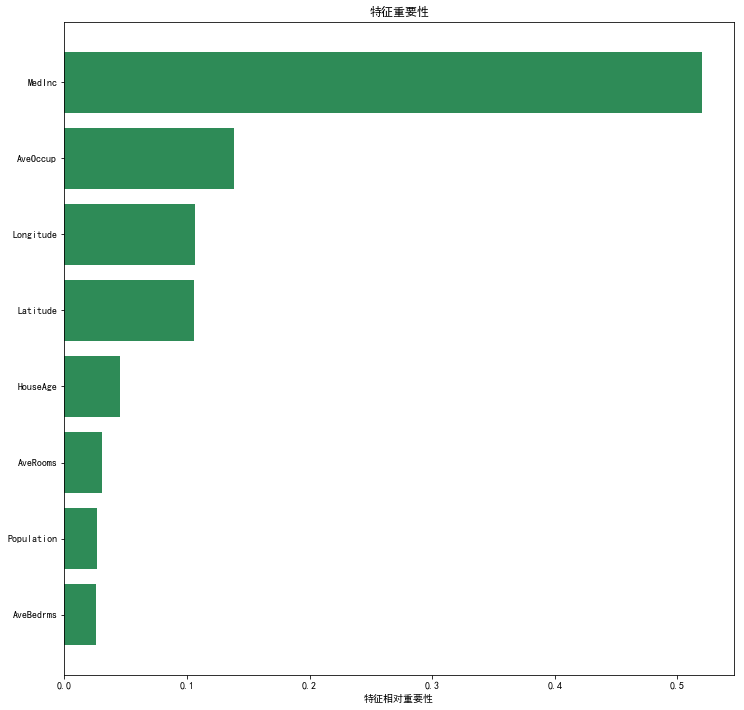

In [44]:
# 可视化特征重要性
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
%matplotlib inline
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('特征重要性')
plt.barh(range(len(indices)), importances[indices], color='seagreen', align='center')
plt.yticks(range(len(indices)),np.array(dataset.feature_names)[indices])
plt.xlabel('特征相对重要性');

In [45]:
selector = SelectFromModel(clf, prefit=True, threshold='median')
# 阈值被设定为'median', 即以特征重要性的中位数作为阈值，大约为0.076
# 我们还可以设置max_features参数以选择最重要的前几个特征

transformed_train = selector.transform(train_set)
transformed_test = selector.transform(test_set)
assert np.array_equal(transformed_train, train_set[:,[0,5,6,7]]) 
# 选择来第1个，第6个, 第7个及第8个特征
assert np.array_equal(transformed_test, test_set[:,[0,5,6,7]]) 